Kaggle Titanic Dataset Competition
----
Let's import the necessary libraries, then start some exploratory analysis.

In [46]:
from collections import Counter, defaultdict
from functools import partial
import math, random, csv
import matplotlib.pyplot as plt
import dateutil.parser
import functools
import pandas as pd
import numpy as np

Let's load in the initial data.
----

In [47]:
data = pd.read_csv("datasets/titanic_train.csv")  # Reading in the data
tgt  = data["Survived"]                           # Retain a copy of the target variable
#data = data.drop(["Survived"], axis=1)            # Remove the target value from the dataset.
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [48]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Next, let's checkout the cleanliness of our dataset.
----

In [49]:
nullity = pd.isnull(data).any(axis=0)
print(nullity)

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool


Null value discussion
----
So from calling isnull on the pandas dataframe containing the dataset, we've been able to figure out which columns include null values, or "None", and need to be cleaned. We can see that there are three different variables containing missing values:

- $\textbf{Age}$: Purely quantitative variable representing the subject's age. In order to fill null age data, you could utilize the mean age of all passengers aboard the Titanic. This way, we're not adding too much new information with unnecessarily drawn conclusions about age from other variables. We leave this at the mean to smooth out the noise that a zero, or null, value causes.


- $\textbf{Cabin}$: Qualitative variable representing the cabin number. If you take a look back at the summary of the data, you will see entries like "C85" and "C123". In order to solve the nullity issue with this variable, you could either choose to remove the variable's data from the dataset altogether, or essentially make not having a room a feature in your dataset, which is a move that could add unecessary bias. Right after this, we'll look a little more into Cabin.


- $\textbf{Embarked}$: Qualitative variable representing the location of embarkation of the subject.


Let's tackle Age first.
----

In [50]:
age_mean = data["Age"].dropna().mean() # Accesses "Age", removes the None values, and calculates the mean.
data["Age"] = data["Age"].fillna(age_mean)
        
print("The Mean Age is: " + str(age_mean))
print("Variable nullity: " + str(pd.isnull(data["Age"]).any()))

The Mean Age is: 29.6991176471
Variable nullity: False


Whew! Alright, not too bad. We've effectively replaced all "None" values in the "Age" variable with the mean, and have solved one of our three null value issues.

After that, let's assess Cabin.
----
Before we decide if we want to chuck the entire variable, let's see how big of an issue the nullity is.

In [51]:
cabin_nullity = data["Cabin"].isnull().sum()
cabin_size    = len(data["Cabin"])

print("The number of None Cabin records: " + str(cabin_nullity))
print("The total number of records: " + str(cabin_size))
print("Proportion missing: " + str(float(cabin_nullity)/float(cabin_size)*100))

The number of None Cabin records: 687
The total number of records: 891
Proportion missing: 77.1043771044


Yikes.
----
Keeping in mind that almost 80% of the Cabin data is missing, let's just completely throw that variable out.

In [52]:
data = data.drop(["Cabin"], axis = 1)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Finally, let's approach Embarked.
----
Like Cabin, let's check out what proportion of the data has a missing Embarked value.

In [53]:
embarked_nullity = data["Embarked"].isnull().sum()
embarked_size    = len(data["Embarked"])

print("The number of None Cabin records: " + str(embarked_nullity))
print("The total number of records: " + str(embarked_size))
print("Proportion missing: " + str(float(embarked_nullity)/float(embarked_size)*100))

The number of None Cabin records: 2
The total number of records: 891
Proportion missing: 0.224466891134


In this case, very few are missing Embarked.
---
Because of this, instead of removing this variable, a valid next step would be to either place a random value from the rest of the embarkation location encodings for the two missing subjects, or you could simply remove those subjects from the dataset. Let's look a little closer, and actually extract the records of the passengers of unknown origin.

In [54]:
embarked = data["Embarked"].values

missing = []
for x in range(len(embarked)):
    if str(embarked[x]) == "nan":
        missing.append(x)
        
for x in missing:
    print("Missing subject:")
    print(data.ix[x])
    print("\n")
    
print("Average fare: " + str(data["Fare"].mean()))

Missing subject:
PassengerId                     62
Survived                         1
Pclass                           1
Name           Icard, Miss. Amelie
Sex                         female
Age                             38
SibSp                            0
Parch                            0
Ticket                      113572
Fare                            80
Embarked                       NaN
Name: 61, dtype: object


Missing subject:
PassengerId                                          830
Survived                                               1
Pclass                                                 1
Name           Stone, Mrs. George Nelson (Martha Evelyn)
Sex                                               female
Age                                                   62
SibSp                                                  0
Parch                                                  0
Ticket                                            113572
Fare                                      

E:\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


Aha!
----
Two older ladies travelling together with a ticket costing approximately twice the average fare (before cleaning), which would follow that they'd be normal passengers and not significant outliers in any way except higher than average ages. To avoid adding bias into the dataset by making assumptions and drawing conclusions based upon incomplete data, I'm chosing to remove the records that are missing their Embarked value.

In [55]:
# Drop the rows/passengers with missing Embark data.
for loc in missing:
    data = data.drop(loc)

And...
---

In [56]:
nullity = pd.isnull(data).any(axis=0)
print(nullity)

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Embarked       False
dtype: bool


Woop! We've taken care of all of the null values!
----
Let's take this opportunity to make a clean backup of our data.

In [57]:
clean_data = data
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Next, it's time to understand our quantitative variables a little better.
----
Let's start by visualizing:

- Pclass: Ticket Class
- Age: Age in Years
- SibSp: Number of siblings/spouses aboard
- Parch: Number of parents/children aboard
- Fare: Passenger fare

Histogram binning of Qualitiative Variables.
----

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001D75C048>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000001EAC2908>]], dtype=object)

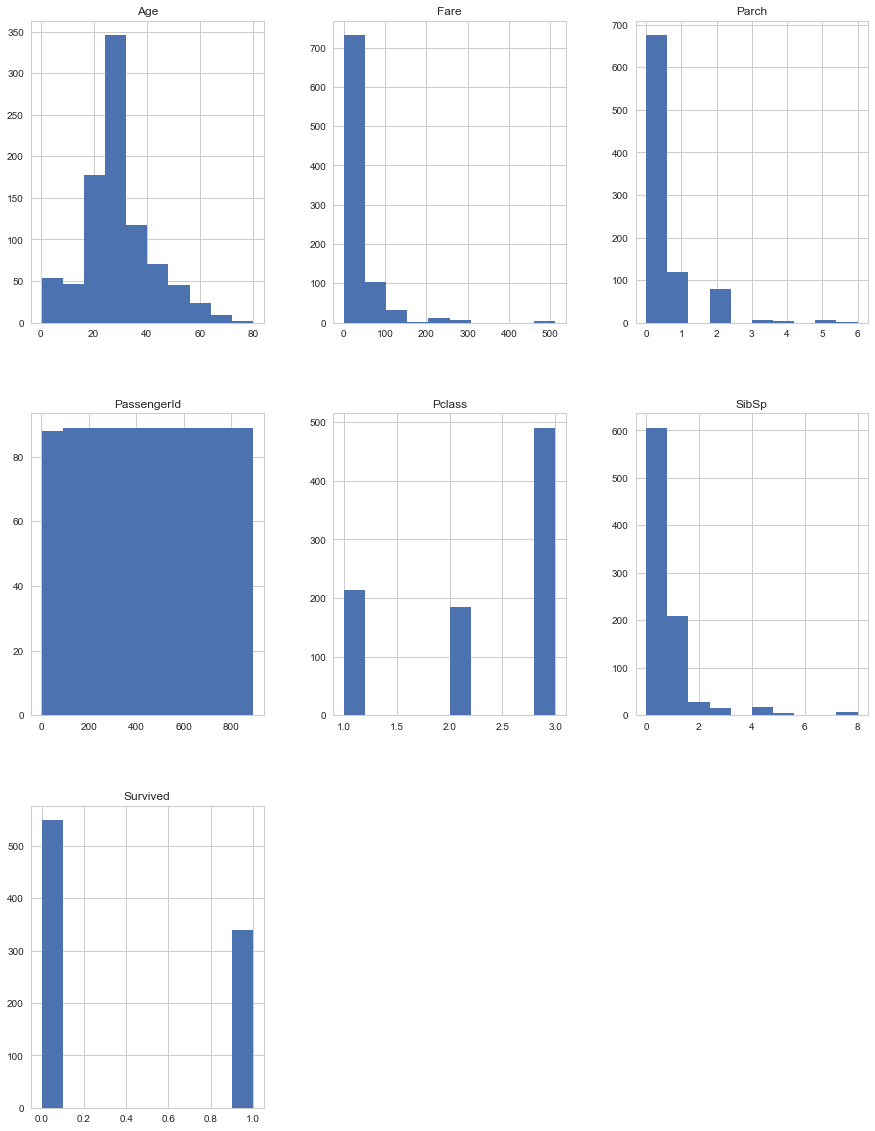

In [58]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data.hist(ax = ax)

Let's talk about each individually, starting with Age
---
If you look at the Age data, you can see that it behaves pretty much like you'd expect. A large number of people aged 20-30, with the age representation tapering to approximately 80 years old at the eldest passenger, which, again is as expected. There's nothing out of the ordinary about Age now that it's had its Null values replaced with the mean.

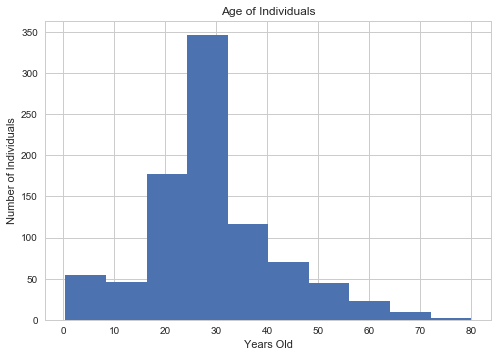

In [59]:
data["Age"].hist()
plt.title("Age of Individuals")
plt.ylabel("Number of Individuals")
plt.xlabel("Years Old")

Fare
----
The data in fair also look about like what you'd expect, with the potential of a few outliers. If you see, there are a few tickets that are a lot more expensive than the rest, ballpark 500 pounds. Let's check out those profiles and see if there's anything weird about them.

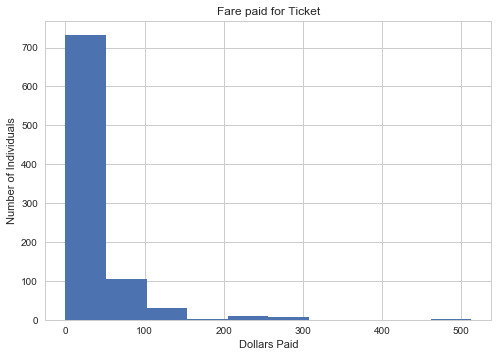

In [60]:
data["Fare"].hist() 
plt.title("Fare paid for Ticket")
plt.ylabel("Number of Individuals")
plt.xlabel("Dollars Paid")

Fare Insight
----
From looking at the outlier grouping, we can actually see that all three of these individuals were on the same ticket, and paid the exact same amount. This leads me to believe that this potentially may be the structure of the data, and as such we'll be able to get a deeper understanding of the social network of the passengers on board. I would also conclude that there's nothing out of the ordinary about the price; Three first class tickets for a middle aged (for the time) group of individuals who could've paid for large amounts of luggage to be shipped. I also confirmed the price of the ticket by doing some research online into Titanic survivors.

A good to-do from this is encoding ticket IDs into cluster IDs.

In [61]:
fare_outliers = [x for x in data["Fare"] if x > 300]
print("Outlier values: " + str(fare_outliers))

for index, row in data.iterrows():
    if row['Fare'] > 300:
        print("")
        print row

Outlier values: [512.32920000000001, 512.32920000000001, 512.32920000000001]

PassengerId                 259
Survived                      1
Pclass                        1
Name           Ward, Miss. Anna
Sex                      female
Age                          35
SibSp                         0
Parch                         0
Ticket                 PC 17755
Fare                    512.329
Embarked                      C
Name: 258, dtype: object

PassengerId                                   680
Survived                                        1
Pclass                                          1
Name           Cardeza, Mr. Thomas Drake Martinez
Sex                                          male
Age                                            36
SibSp                                           0
Parch                                           1
Ticket                                   PC 17755
Fare                                      512.329
Embarked                                    

Parch
----
Let's check out how the data for parents and children. From looking at this histogram, you can see that the majority of the passengers were on the boat alone, and comparatively few actually had others that they were travelling with. Especially in a survival situation, having more people to take care of could be the difference between survival and not making it.

Let's look at the representation of passengers with and without accompaniment.

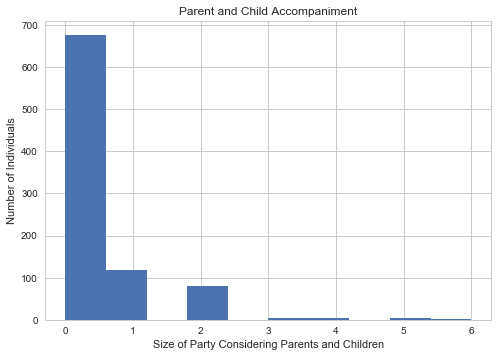

In [62]:
data["Parch"].hist()    
plt.title("Parent and Child Accompaniment")
plt.ylabel("Number of Individuals")
plt.xlabel("Size of Party Considering Parents and Children")

In [63]:
alone  = float(len([x for x in data["Parch"] if x == 0]))
friend = float(len([x for x in data["Parch"] if x > 0]))
both   = alone + friend

print("Proportion travelling alone: " + str((alone/both)*100))
print("Proportion travelling with accompaniment: " + str((friend/both)*100))
print("Most common overall Parch value: " + str(data["Parch"].mean()))

# Let's check out the mean value of those with accompaniment
accompanied = [x for x in data["Parch"] if x > 0]
print("Most common accompanied Parch value: " + str(float(sum(accompanied))/float(len(accompanied))))

Proportion travelling alone: 76.0404949381
Proportion travelling with accompaniment: 23.9595050619
Most common overall Parch value: 0.382452193476
Most common accompanied Parch value: 1.59624413146


SibSp
---
For the sibling/spousal variable, let's do the exact same thing.

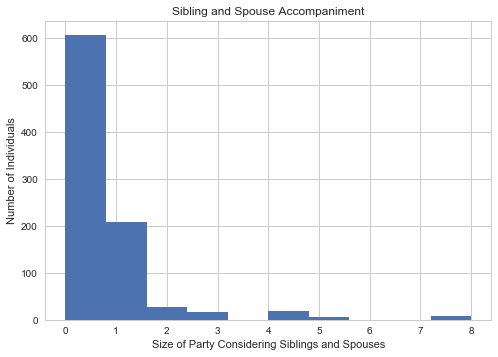

In [64]:
data["SibSp"].hist()
plt.title("Sibling and Spouse Accompaniment")
plt.ylabel("Number of Individuals")
plt.xlabel("Size of Party Considering Siblings and Spouses")

In [65]:
alone  = float(len([x for x in data["SibSp"] if x == 0]))
friend = float(len([x for x in data["SibSp"] if x > 0]))
both   = alone + friend

print("Proportion travelling alone: " + str((alone/both)*100))
print("Proportion travelling with accompaniment: " + str((friend/both)*100))
print("Most common overall SibSp value: " + str(data["SibSp"].mean()))

# Let's check out the mean value of those with accompaniment
accompanied = [x for x in data["SibSp"] if x > 0]
print("Most common accompanied SibSp value: " + str(float(sum(accompanied))/float(len(accompanied))))

Proportion travelling alone: 68.1664791901
Proportion travelling with accompaniment: 31.8335208099
Most common overall SibSp value: 0.52418447694
Most common accompanied SibSp value: 1.64664310954


Let's look into the structure of the shared tickets
---
Earlier, we said that there may be some structure to the shared tickets. Let's check out how SibSp, Parch, and Ticket all tie in together by visualizing the passengers that shared tickets alongside those who came alone.

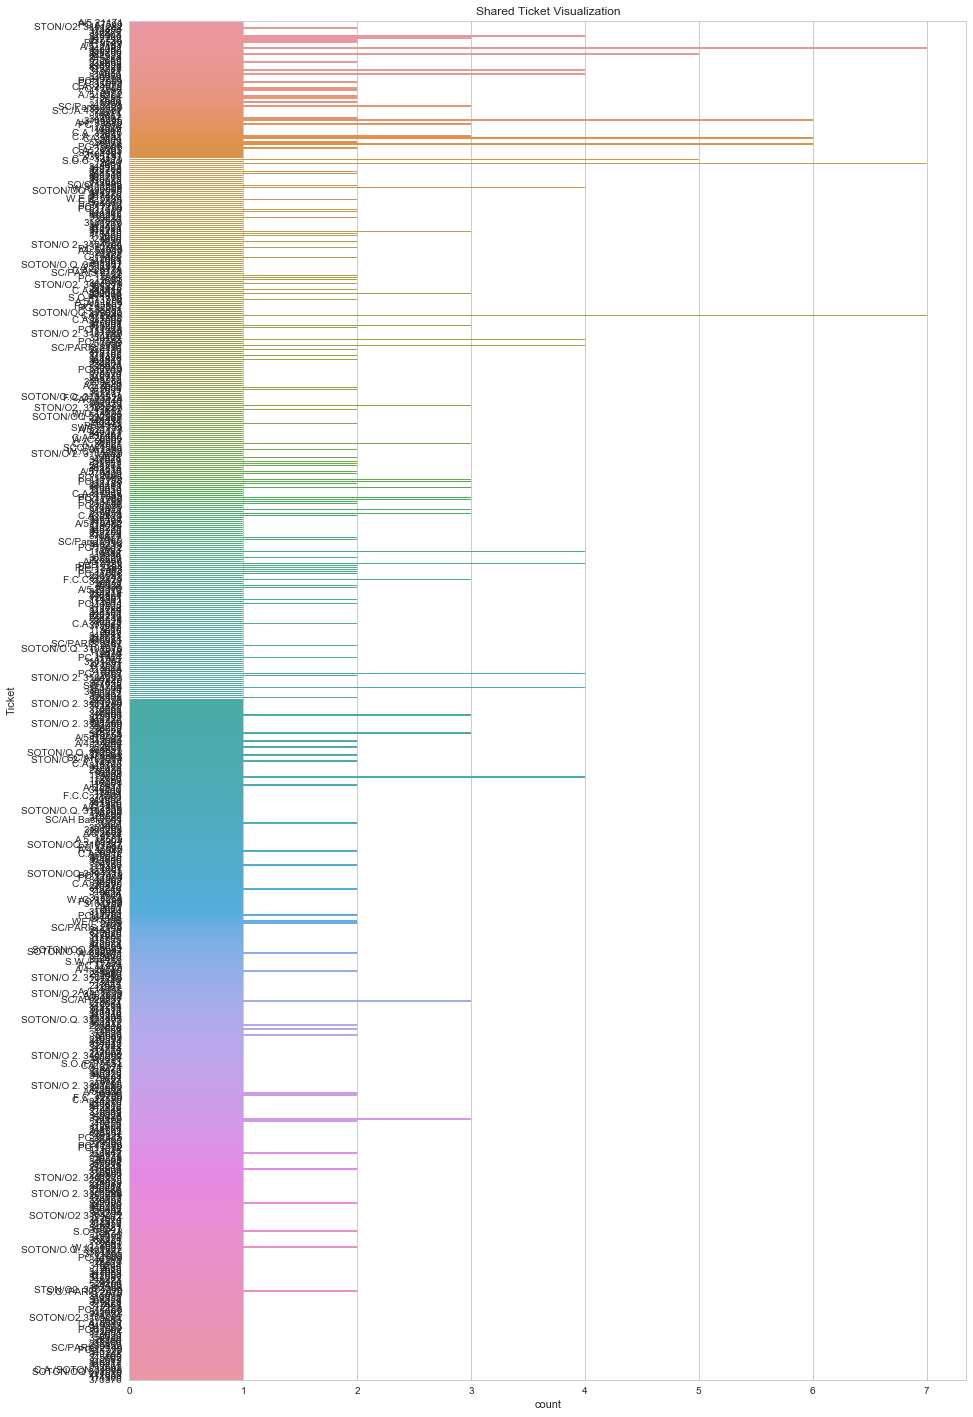

In [66]:
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

fig = plt.figure(figsize = (15,25))
ax = fig.gca()

sns.countplot(y="Ticket", data=data, linewidth=2, ax=ax)
plt.title("Shared Ticket Visualization")
plt.show()

PClass
----
Luckily, PClass is simply 1, 2 or 3. It doesn't look like it behaves irregularly. The only issue may be in that PClass is inherently given a negative connotation due to the hierarchy of the values; 3 could be deemed above 1 and 2, though logically we know that in our culture, "First Class" is the best, and this is also reflected by the sparsity of first class tickets held with the sparsity of higher priced tickets.

Mostly a mental note.

Now that we've got a better understanding of the variables as they exist independently, let's continue on to look at correlation, covariance, and multivariate summaries of the data.

Graphical Correlation Matrix
----
Source: https://seaborn.pydata.org/generated/seaborn.pairplot.html

If you look to the right of the Correlation Matrix, you'll see the key. Blue has been attributed to non-survival, and Green has been attributed to those passengers that survived.

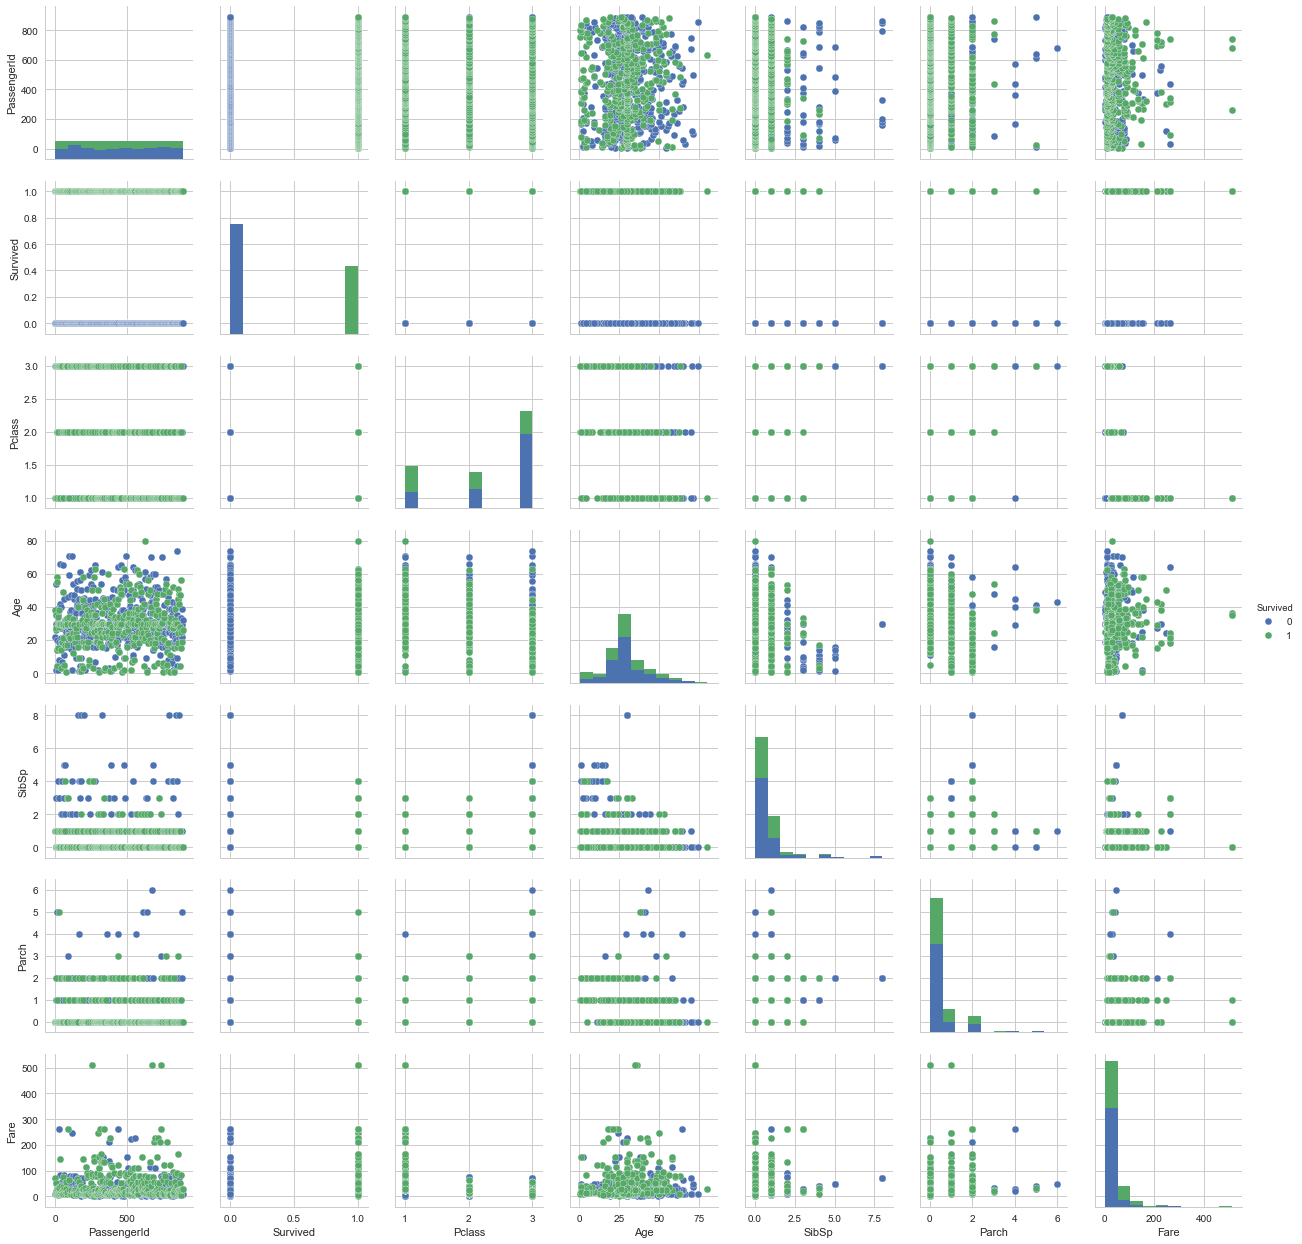

In [72]:
sns.pairplot(data, hue="Survived")

Quantitative Correlation Matrix
----

In [73]:
data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005028,-0.035330,0.030300,-0.057686,-0.001657,0.012703
Survived,-0.005028,1.000000,-0.335549,-0.074673,-0.034040,0.083151,0.255290
Pclass,-0.035330,-0.335549,1.000000,-0.327954,0.081656,0.016824,-0.548193
Age,0.030300,-0.074673,-0.327954,1.000000,-0.231875,-0.178232,0.088604
SibSp,-0.057686,-0.034040,0.081656,-0.231875,1.000000,0.414542,0.160887
Parch,-0.001657,0.083151,0.016824,-0.178232,0.414542,1.000000,0.217532
Fare,0.012703,0.255290,-0.548193,0.088604,0.160887,0.217532,1.000000


Let's zoom into some of the more interesting correlations. Time for handwaving!
----

Survival, Pclass and Fare:
---
If you look at the quantitative correlation matrix, you'll see that Fare and Pclass have an anti-correlation of -0.54 on a [-1, 1] scale. Weird! Why would that be? Let's think back to the encoding of Pclass we talked about. The best, most optimal class, on the Titanic was first class. Following that, second class is middle however you run the numbers, but third class is the worst. If you think in terms of linear progression, as the value of class increases, the average cost of the fare decreases.

Now, you may be asking yourself, how does this tie back into Survival, and why is it important? Well, if you look at Survived and Pclass, there's an anti-correlation of -0.33! Keeping in mind that Fare and Pclass have an anti correlation as well, it can be concluded that there is a positive correlation with class and survival of 0.33, if you consider that "First class" should actually be ranked highest.

This is an important insight to check out during PCA; How well does the PClass variable explain the survivability outcome of this passenger? If what we've learned holds true, because Pclass (and thus further, Fare) have the highest correlation with survival, those variables should have high Principle Component 1 coefficients.

Age, Pclass and Fare:
---
Pclass and Age have an anti-correlation of -0.32, which indicates that older passengers were likelier to be either middle or first class passengers. Following that, age has a slightly negative correlation with survival. What can be inferred is that there were few enough wealthy passengers that were older to essentially disregard out the high correlation of age with class.

My assertion is that no matter if you were higher class, if you were older, you likely parished. On the other hand, if you were simultaneously younger and higher class (i.e., wealthier), you had a much higher chance of surviving the Titanic.

Age, SibS and Parch:
---
